In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab.patches import cv2_imshow # cv2_imshow(img)
import cv2
import urllib.request
import numpy as np
import time
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import PIL.Image
import matplotlib.image as img
import IPython.display as display

In [3]:
def model_layers(layer_names): # 전역 변수1, StyleContentModel에 이용
    """ 중간층의 출력값을 배열로 반환하는 < > 모델을 만듭니다."""
    # 이미지넷 데이터셋에 사전학습된 < > 모델을 불러옵니다
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [4]:
def gram_matrix(input_tensor): # StyleContentModel에 이용
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [5]:
def load_img(path_to_img): # main, 적역변수 1에 이용
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img, new_shape

In [6]:
# 전역 변수1 선언
content_layers = ['block5_conv2']  # 전역변수 2 extractor에 이용
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']     # 전역변수 2 extractor에 이용
num_content_layers = len(content_layers) # style_content_loss 에 이용
num_style_layers = len(style_layers) # style_content_loss 에 이용
style_extractor = model_layers(style_layers)
style_location = '/content/drive/MyDrive/Colab Notebooks/data/style/udnie.jpg'
style_image, style_shape = load_img(style_location) # style_content_loss 에 이용
style_outputs = style_extractor(style_image*255) # style_content_loss, StyleContentModel에 이용

In [7]:
class StyleContentModel(tf.keras.models.Model): # 전역변수 2 extractor에 이용
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  model_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [8]:
# 전역 변수2 선언
extractor = StyleContentModel(style_layers, content_layers) # style_content_loss, train_step에 이용

In [9]:
def clip_0_1(image):  # train_step에 이용
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [10]:
def style_content_loss(outputs):  # train_step에 이용
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    style_weight=1e-2
    content_weight=1e4
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                        for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [11]:
# @tf.function()
def train_step(image):  # get_transformed_img에 이용
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [12]:
def tensor_to_image(tensor): # get_transformed_img에 이용
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [13]:
def get_transformed_img(content_image): # main에 이용    
    image = tf.Variable(content_image)
    
    epochs = 3
    steps_per_epoch = 1
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print(".", end='')
        # display.clear_output(wait=True)
        # display.display(tensor_to_image(image))
        # print("훈련 스텝: {}".format(step)) 
    img_transformed = np.array(tensor_to_image(image))
    return img_transformed

In [18]:
# main 함수 디버깅 용
location = '/content/drive/MyDrive/Colab Notebooks/data/knight/dash_2.png'
url = 'https:' + '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e2.e4f4f2d4-547f-47af-a24b-b0c46368f69b.png'
urllib.request.urlretrieve(url, location)

content_image, content_shape = load_img(location)
img_transformed = get_transformed_img(content_image)
origin_image = img.imread(location)

...

[1.]
[0.0000000e+00 6.1274513e-05 1.2254903e-04 ... 9.9987745e-01 9.9993873e-01
 1.0000000e+00]


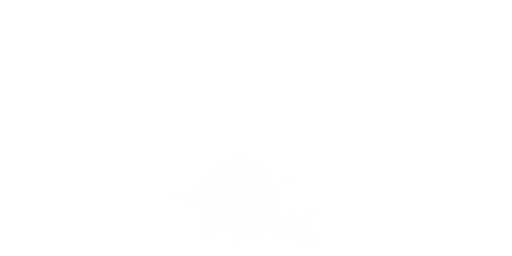

In [19]:
'''
# image urls
dash_1 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e0.11128ebc-b5af-4a57-9f30-7ff1248c7ee2.png'
dash_2 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f4e2.e4f4f2d4-547f-47af-a24b-b0c46368f69b.png'
dash_3 = '//assetstorev1-prd-cdn.unity3d.com/preview/01d0f472.8fb14c53-318c-46dc-a7d6-190c6234f499.png'
imgUrls = [dash_1, dash_2, dash_3]

# for idx, elem in enumerate(imgUrls):
idx = 1
elem = dash_1
    
# original image download
url = 'https:' + elem
filename = 'dash_' + str(idx+1)
location = f'/content/drive/MyDrive/Colab Notebooks/data/knight/{filename}.png'
urllib.request.urlretrieve(url, location)

# # style image download
# style_url = 'http://artisty.co.kr/custom/img/upload/thumb/14018_m11_thumb.jpg'
# style_location = '/content/drive/MyDrive/Colab Notebooks/data/style.png'
# urllib.request.urlretrieve(style_url, style_location)
# style_location = '/content/drive/MyDrive/Colab Notebooks/data/style/udnie.jpg'  # 전역변수 1
'''
# origin_image = img.imread(location)

# # style transfer
# content_image, content_shape = load_img(location) # content_shape : [256 512]
# style_image, style_shape = load_img(style_location)
# img_transformed = get_transformed_img(content_image, style_image)

cv2.imwrite(location, img_transformed) # 덮어 쓰기  이거 이전에 origin_image 선언해야
img_transformed = img.imread(location) # 저장하고 다시 읽는 이유 : 바로 img_transformed 변수 쓰니까 에러 뜸

# model이 반환한 이미지와 사이즈 동일하게 origin image 변환
shape = content_shape.numpy()
x, y = shape
origin_image_resized = cv2.resize(origin_image, dsize=(y,x))

# add alpha channel
final = cv2.cvtColor(img_transformed, cv2.COLOR_RGB2RGBA)
print(np.unique(final[:,:,3]))
alpha = origin_image_resized[:,:,3]
final[:, :, 3] = alpha
print(np.unique(final[:,:,3]))
# cv2.imwrite(location, final) # 덮어 쓰기
# print(f'{filename}.png saved Successfully')
cv2_imshow(final)